# Residual Convolution

A convolutional neural network based on residual convolution for image classification to digit sign recognition The system architecture of this project consists of 50 layers; TensorFlow Keras is used as the framework to be implemented. Accuracy is used to calculate system performance.

## 1. Required packets 
There are multiple packets required to implement this ResNet project. The packets are listed below.

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

%matplotlib inline

## 2. Resent Concept

The residual concept is used to address the vanishing gradient problem by making it easier for the network to learn and make use of residual connections, which are shortcuts that skip one or more layers in the network. These connections improve information flow and can speed up training.

<img src="images/1.png" width="100"/>

**Residual Block type**

### A. Identical connection 

There are two type of Residual first if the layer L connect to layer L+n and both of the layers have same output shape, in this case the shourtcut done between them as equation below

"Residual of layer L and L+n = $a^{[L+n]} = Relu(w^{[L+n]}\cdot a^{[L+n-1]} + a^{[L]} + b^{[L+n]})$"

Skip connection "skips over" 3 layers

### The identity block artchitecture

**block one**
1. Conv2D, kernel_size = (1,1), stride = 1, padding = valid -> batch normalization -> RelU

**block Two**

2. Conv2D, kernel_size = (f,f), stride = 1, padding = same ->  batch normalization -> RelU

**block three**

3. Conv2D, kernel_size = (1,1), stride = 1, padding = valid ->  batch normalization ->



Connect the result with the input using Add(shortcut) -> RelU



<img src="images/2.png" width="600"/>


In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # Layer one
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Layer Two
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    #Layer Three
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    #ShortCut with input
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    #

    return X

### B. Not Identical connection

If layer L connects to layer L+n and the the layers have differs shape, a new W with the shape (L+n, L) is required to overcome the shape difference, and the connect between them is done as the following equation:  

"Residual of layer L and L+n = $a^{[L+n]} = Relu(w^{[L+n]}\cdot a^{[L+n-1]} +  Ws(L+n, L) \cdot a^{[L]} + b^{[L+n]})$"

### The Not indentical block Artchitecture

**block one**
1. Conv2D, kernel_size = (1,1), stride = s, padding = valid -> batch normalization -> RelU

**block Two**

2. Conv2D, kernel_size = (f,f), stride = 1, padding = same ->  batch normalization -> RelU

**block three**

3. Conv2D, kernel_size = (1,1), stride = 1, padding = valid ->  batch normalization -> 


**Shortcut path**

4. Conv2D, kernel_size = (1,1), stride = s, padding = valid -> batch normalization

Convolute the input with the same filter as the last layer, then apply batch noramalization; after that, make  the shoutcut and RelU.


<img src="images/3.png" width="600"/>

In [3]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # Layer one
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    
    # Layer two
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Layer three
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    # Make the shortcut as the layer three shape
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 
    
    #

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## 3. The Whole Model 
The complete model of Residual is consist of 50 layers, the details of the layers show belwo

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f= 3, filters = [128,128,512], s=2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(2,2)(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
# Call the model 

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

 conv2d_10 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 15, 15, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 15, 15, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 8, 128)   512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 4, 4, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 2, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['activation_48[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense (De

Add the optimizer method (in this case, Adam), the loss function, and the metric. 

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4. Load the Dataset

In [7]:
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

The Y is an array consisting of one row and 1080 columns. Each column value ranges from 0 to 5, representing the image digit; however, this type of data cannot be used directly in our model. To do it correctly, first use **np.reshape(-1)** to convert the Y form (1,1080) to (1080,1), then use **np.eye(number of classes)** to convert each value into an array of length 6. For example, if the original value is 3, the new value should be [0,0,0,1,0,0], and this is only accepted for the softmax activation function.

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    
    return Y

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
convert_to_one_hot(Y_train_orig,6).shape

(1080, 6)

In [11]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 136s 3s/step - loss: 1.8407 - accuracy: 0.4787
Epoch 2/20
34/34 [==============================] - 121s 4s/step - loss: 0.7355 - accuracy: 0.7426
Epoch 3/20
34/34 [==============================] - 131s 4s/step - loss: 0.7728 - accuracy: 0.7481
Epoch 4/20
34/34 [==============================] - 126s 4s/step - loss: 0.3278 - accuracy: 0.8750
Epoch 5/20
34/34 [==============================] - 129s 4s/step - loss: 0.3058 - accuracy: 0.9009
Epoch 6/20
34/34 [==============================] - 118s 3s/step - loss: 0.1314 - accuracy: 0.9602
Epoch 7/20
34/34 [==============================] - 126s 4s/step - loss: 0.1826 - accuracy: 0.9343
Epoch 8/20
34/34 [==============================] - 121s 4s/step - loss: 0.6310 - accuracy: 0.8306
Epoch 9/20
34/34 [==============================] - 109s 3s/step - loss: 0.7962 - accuracy: 0.7472
Epoch 10/20
34/34 [==============================] - 114s 3s/step - loss: 0.2775 - accuracy: 0.8991
Epoch 11/

In [12]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 359ms/step - loss: 0.3962 - accuracy: 0.9167
Loss = 0.3962426483631134
Test Accuracy = 0.9166666865348816


## 5. Test the model 

1/1 [==============================] - 0s 41ms/step
The number of this image is 5


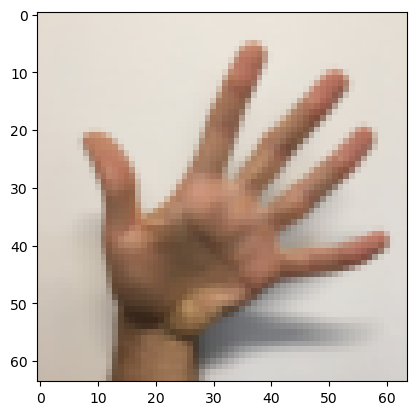

In [88]:
import random

index = random.randint(0, X_test.shape[0])

plt.imshow(X_test_orig[index])  # display sample training image
# plt.show()
# print(X_test[0:1].shape)

which_digit = np.squeeze(model.predict(X_test[index:index+1]))

dose_find_the_number = np.where(which_digit > 0.5)

if dose_find_the_number[0].size:
    number = np.where(which_digit > 0.5)[0][0]
    
    print("The number of this image is", number)
else:
    print("Can not find the correct number")

In [97]:
## 6. Performance Evaluation 


{'verbose': 1, 'epochs': 1, 'steps': 1}